# Heat Transfer through a Window
This script produces a graph comparing PDFs of heat flux generated using NISP full and sparse quadrature methods and a MC sampling method.
Look at the manual example Forward Propagation of Uncertainty with PyUQTk for more explanation.

In [1]:
#general imports

from __future__ import print_function

try:
	import numpy as np
except ImportError:
	print("Numpy module could not be found")

try:
	import matplotlib.pyplot as plt
	from matplotlib import rc
	rc('mathtext', default='regular')
except ImportError:
	print("Matplotlib not found")
    
try:
	from scipy import stats
except ImportError:
	print("Scipy stats module could not be found")

try:
    import PyUQTk.pce as uqtkpce
except ImportError:
    print("PyUQTk PCE module not found")

try:
    import PyUQTk.PyPCE.pce_tools as pce_tools
except ImportError:
    print("PyUQTk pce_tools module not found")   

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


In [2]:
#problem-specific imports
try:
    from heat_transfer_pce_tools import *
except ImportError:
    print("File with PCE utilities not found.")

## Setting input arguments

In [3]:
#If executing in command line, one would use these variables as flags.
#Example inputs are good starting inputs.

#--no_verbose: Turns off intermediate print statements
#type=int, example=1
main_verbose = 0

# -r, --no_compute_rad: Whether to calculate with radiation
#type=bool, example=True
compute_rad = True

# --nord: Order of the PCE
#type=int, example=3
nord = 3

# --ndim: Dimension of the PCE
#type=int, example=None, None activates default settings
ndim = None

# --pc_type: Polynomial type and the weighting function
#type=str, example="HG"
pc_type = "HG"

# -a: Free parameter greater than -1 for Gamma-Laguerre and Beta-Jacobi PC types
#type=float, example=0.0
pc_alpha = 0.0

#-b: Free parameter greater than -1 for Gamma-Laguerre and Beta-Jacobi PC types
#type=float, example=1.0
pc_beta = 1.0 #type=float

# --param, Number of quadrature points per dimension
#type=int, example=nord+1, None activates default settings
param = nord + 1

# --n_MC: Number of random samples for MC sampling (of the full problem or of the PCE of the solution)
#type=int, example=100000
n_MC = 100000

if main_verbose > 0:
    print("\nConsidering heat transfer with", end= ' ')
    if not compute_rad:
        print("no ",end= ' ')
    print("radiation.")

In [4]:
#Default settings for parameters that equal "None"

# Number of dimensions of the PCE (number of uncertain variables)
if(not ndim):
	if compute_rad:
	    ndim = 7
	else:
	    ndim = 6

In [5]:
# Nominal values of the parameters used to calculate the heat flux
# These values are the same as shown in tha table in example forward propgation of uncertainty with PyUQTk in the manual

Ti = 293.0 # Room temperature in K
To = 273.0 # Outside temperature in K
dw = 0.01  # Window thickness in m
kw = 1.0   # Window conductivity in W/mK
hi = 2.0   # Inner convective heat transfer coefficient in W/m^2K
ho = 6.0   # Outer wall convective heat transfer coefficient in W/m^2K
TA = 150.0 # Atmospheric temperature in K. Only used to calculate heat flux when it is assumed that radiative heat transfer occurs

# Set the standard deviations of the Gaussian uncertainty of these uncertain parameters
std_Ti=Ti*0.005
std_To=To*0.005
std_dw=dw*0.01
std_kw=kw*0.05
std_hi=hi*0.15
std_ho=ho*0.15
std_TA=TA*0.1

## Forward propagation using Monte Carlo sampling

In [6]:
#Generate random samples (as 1D vectors) of the uncertain parameters
samp_Ti=np.random.normal(Ti, std_Ti, n_MC)
samp_To=np.random.normal(To, std_To, n_MC)
samp_dw=np.random.normal(dw, std_dw, n_MC)
samp_kw=np.random.normal(kw, std_kw, n_MC)
samp_hi=np.random.normal(hi, std_hi, n_MC)
samp_ho=np.random.normal(ho, std_ho, n_MC)
if compute_rad:
    samp_TA=np.random.normal(TA, std_TA, n_MC)

# Evaluate heat transfer model for all parameter samples, computing the heat flux Q
# Q_evals is an array of evaluations of the forward model. 
if not compute_rad: #without radiation, solving 3 linear equations
    Q_evals=fwd_model(samp_Ti,samp_To,samp_dw,samp_kw,samp_hi,samp_ho,main_verbose)
else: #with radiation, first estimating without considering radiation and then using a nonlinear solver
    Q_evals=fwd_model_rad(samp_Ti,samp_To,samp_dw,samp_kw,samp_hi,samp_ho,samp_TA,main_verbose)

# Perform kernel density estimation on Q_evals
# xpts_MC is an array of points at which the PDF was estimated
# PDF_data_MC is an array of the corresponding estimated PDF values.
xpts_MC, PDF_data_MC= pce_tools.UQTkKDE(Q_evals)

## Forward propagation using PCEs and full quadrature

In [7]:
# Instantiate PC Object with full quadrature methods
# Contains all of the information needed about the PCE, including number of dimensions, order of the expansion, and sparsity
pc_model = uqtkpce.PCSet("NISP", nord, ndim, pc_type, pc_alpha, pc_beta) 

pc_model.SetQuadRule(pc_type, 'full', param)
npce = pc_model.GetNumberPCTerms() # Number of terms in the PCE
if main_verbose > 0:
    print("The number of terms in each PCE is", npce)
    print("Multi-index and norm squared for all terms:")
    pc_model.PrintMultiIndexNormSquared()

#Get NumPy array of quadrature points, qdpts
#totquat is the total number of quad points
qdpts, totquat = pce_tools.UQTkGetQuadPoints(pc_model)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
# Taking advantage of the fact that inputs are assumed to be Gaussian
# Following parameter_samples = μ + σ(qdpts)
# This is equivalent to evaluating 1st order PC expansions for the input parameters.

Ti_samples = Ti + std_Ti * qdpts[:,0]
To_samples = To + std_To * qdpts[:,1]
dw_samples= dw + std_dw * qdpts[:,2]
kw_samples= kw + std_kw * qdpts[:,3]
hi_samples= hi + std_hi * qdpts[:,4]
ho_samples= ho + std_ho * qdpts[:,5]
if compute_rad:
    TA_samples= TA + std_TA * qdpts[:,6]

# Evaluate forward model for sampled parameters, computing the heat flux Q
# Q_evals is an array of evaluations of the forward model
if not compute_rad: #without radiation, solving 3 linear equations
    Q_evals=fwd_model(Ti_samples,To_samples, dw_samples, kw_samples,hi_samples,ho_samples,main_verbose)
else: #with radiation, first estimating without considering radiation and then using a nonlinear solver
    Q_evals=fwd_model_rad(Ti_samples,To_samples, dw_samples, kw_samples,hi_samples,ho_samples,TA_samples,main_verbose)

# Galerkin Projection
c_k = pce_tools.UQTkGalerkinProjection(pc_model, Q_evals)

pc_model.SeedBasisRandNumGen(123)

#Draw samples of PCE evaulations
pce_evals = pce_tools.UQTkDrawSamplesPCE(pc_model, c_k, n_MC)

#Peform kernel density estimation
xpts_pce, PDF_data_pce=pce_tools.UQTkKDE(pce_evals)

nqp 16384
function eval array 16384


## Forward propagation using PCEs and sparse quadrature

In [8]:
# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISP", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)
npce2 = pc_model2.GetNumberPCTerms() # Number of terms in the PCE
if main_verbose > 0:
	print("The number of terms in each PCE is",npce2)
if main_verbose > 10:
    print("Multi-index and norm squared for all terms:")
    pc_model.PrintMultiIndexNormSquared()

#Get NumPy array of quadrature points, qdpts2
#totquat2 is the total number of quad points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

# Convert Quadrature points in \xi_i to equivalent samples of input parameters
# (taking advantage of the fact that inputs are assumed to be Gaussian)
# This is equivalent to evaluating 1st order PC expansions for the input parameters.
Ti_samples2 = Ti + std_Ti * qdpts2[:,0]
To_samples2 = To + std_To * qdpts2[:,1]
dw_samples2= dw + std_dw * qdpts2[:,2]
kw_samples2= kw + std_kw * qdpts2[:,3]
hi_samples2= hi + std_hi * qdpts2[:,4]
ho_samples2= ho + std_ho * qdpts2[:,5]
if compute_rad:
    TA_samples2= TA + std_TA * qdpts2[:,6]

# Evaluate heat transfer model for all parameter samples, computing the heat flux Q
# Q_evals is an array of evaluations of the forward model. 
if not compute_rad: #without radiation, solving 3 linear equations
    Q_evals2=fwd_model(Ti_samples2,To_samples2, dw_samples2, kw_samples2,hi_samples2,ho_samples2,main_verbose)
else: #with radiation, first estimating without considering radiation and then using a nonlinear solver
    Q_evals2=fwd_model_rad(Ti_samples2,To_samples2, dw_samples2, kw_samples2,hi_samples2,ho_samples2,TA_samples2,main_verbose)

print("npce2", npce2)
print("Quad points from totquat2", totquat2)
print("length of Q_evals", Q_evals2.shape)
# Galerkin Projection
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,Q_evals2)

#Draw samples of PCE evaulations
pce_evals2 = pce_tools.UQTkDrawSamplesPCE(pc_model2, c_k2, n_MC)

#Peform kernel density estimation
xpts_pce2, PDF_data_pce2=pce_tools.UQTkKDE(pce_evals2)

KUKU 0 1
KUKU 0 7
KUKU 1 7
KUKU 2 7
KUKU 3 7
KUKU 4 7
KUKU 5 7
KUKU 6 7
KUKU 0 28
KUKU 1 28
KUKU 2 28
KUKU 3 28
KUKU 4 28
KUKU 5 28
KUKU 6 28
KUKU 7 28
KUKU 8 28
KUKU 9 28
KUKU 10 28
KUKU 11 28
KUKU 12 28
KUKU 13 28
KUKU 14 28
KUKU 15 28
KUKU 16 28
KUKU 17 28
KUKU 18 28
KUKU 19 28
KUKU 20 28
KUKU 21 28
KUKU 22 28
KUKU 23 28
KUKU 24 28
KUKU 25 28
KUKU 26 28
KUKU 27 28
KUKU 0 84
KUKU 1 84
KUKU 2 84
KUKU 3 84
KUKU 4 84
KUKU 5 84
KUKU 6 84
KUKU 7 84
KUKU 8 84
KUKU 9 84
KUKU 10 84
KUKU 11 84
KUKU 12 84
KUKU 13 84
KUKU 14 84
KUKU 15 84
KUKU 16 84
KUKU 17 84
KUKU 18 84
KUKU 19 84
KUKU 20 84
KUKU 21 84
KUKU 22 84
KUKU 23 84
KUKU 24 84
KUKU 25 84
KUKU 26 84
KUKU 27 84
KUKU 28 84
KUKU 29 84
KUKU 30 84
KUKU 31 84
KUKU 32 84
KUKU 33 84
KUKU 34 84
KUKU 35 84
KUKU 36 84
KUKU 37 84
KUKU 38 84
KUKU 39 84
KUKU 40 84
KUKU 41 84
KUKU 42 84
KUKU 43 84
KUKU 44 84
KUKU 45 84
KUKU 46 84
KUKU 47 84
KUKU 48 84
KUKU 49 84
KUKU 50 84
KUKU 51 84
KUKU 52 84
KUKU 53 84
KUKU 54 84
KUKU 55 84
KUKU 56 84
KUKU 57 84
KU

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


npce2 120
Quad points from totquat2 6245
length of Q_evals (6245,)
nqp 6245
function eval array 6245


## Summary information


Monte Carlo sampling used 100000 points
Full quadrature method used 16384 points
Sparse quadrature method used 6245 points

heat_flux_pce.pdf has been saved.


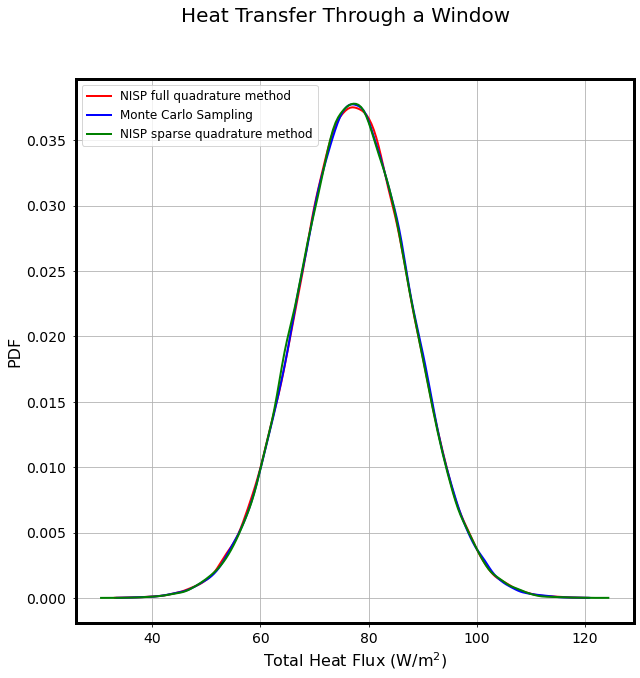

In [9]:
# Print statements to indicate number of samples used
print("\nMonte Carlo sampling used %s points" %(n_MC))
print("Full quadrature method used %s points" %(totquat))
print("Sparse quadrature method used %s points" %(totquat2))

# Plot the three PDF curves on the same figure
plt.figure(figsize=(10,10))
plt.plot(xpts_pce, PDF_data_pce, linewidth=2, color='r', label='NISP full quadrature method')
plt.plot(xpts_MC, PDF_data_MC, linewidth=2, color='b', label='Monte Carlo Sampling')
plt.plot(xpts_pce2, PDF_data_pce2, linewidth=2, color='g', label= 'NISP sparse quadrature method')

# Label axes
plt.xlabel("Total Heat Flux ($W/m^2$)", size=16)
plt.ylabel("PDF", size=16)
# Add title
plt.suptitle("Heat Transfer Through a Window", size=20)
# Change tick size
plt.tick_params(axis='both', labelsize=14)
# Pad tick labels
plt.gca().tick_params(pad=6)
# Create legend
plt.legend(loc='upper left', prop={'size':12})
# Save figure
fig_name="heat_flux_pce.pdf"
plt.savefig(fig_name)
print("\nheat_flux_pce.pdf has been saved.")
# Show figure
plt.show()